On perlmutter: use kernel pytorch-1.13.1

In [ ]:
!pip install nflows

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import os
import torch


from numba import cuda 

from helpers.make_flow import *
from helpers.train_flow import *
from helpers.make_BC import *
from helpers.train_BC import *
from helpers.plotting import *
from helpers.evaluation import *

seed = 8

In [2]:
# computing

device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

Using device: cuda


In [3]:
# Plotting params for later


scaled_bins = [np.linspace(-3.5, 3.5, 50) for i in range(9)]

kwargs_dict = {"SB":  {"density": True,"histtype": "step", "color":"blue", "label": "SB"},
               
               "SBL":  {"density": True,"histtype": "step", "color":"green","label": "SBL"},
               
               "SBH":  {"density": True, "histtype": "step", "color":"purple","label": "SBH"},
               
                "IBL":  {"density": True,"histtype": "step", "color":"orange","label": "IBL"},
               
               "IBH":  {"density": True, "histtype": "step", "color":"pink","label": "IBH"},
               
              "SR":  {"density": True, "histtype": "step",  "color":"red", "label": "SR"},
               
              "SB_samples":  {"density": True,   "histtype": "stepfilled",   "color":"blue",  "label": "SB samples", "alpha": 0.3},
               
               "SBL_samples":  {"density": True,  "histtype": "stepfilled",   "color":"green",  "label": "SBL samples",   "alpha": 0.3},
               
               "SBH_samples":  {"density": True,   "histtype": "stepfilled",   "color":"purple",    "label": "SBH samples",  "alpha": 0.3},
               
               "IBL_samples":  {"density": True,  "histtype": "stepfilled",   "color":"orange",  "label": "IBL samples",   "alpha": 0.3},
               
               "IBH_samples":  {"density": True,   "histtype": "stepfilled",   "color":"pink",    "label": "IBH samples",  "alpha": 0.3},
               
              "SR_samples":  {"density": True,  "histtype": "stepfilled",   "color":"red",    "label": "SR samples",  "alpha": 0.3}}


SBL data has shape (9966, 9).
IBL data has shape (1720, 9).
SR data has shape (35708, 9).
IBH data has shape (20791, 9).
SBH data has shape (73378, 9).


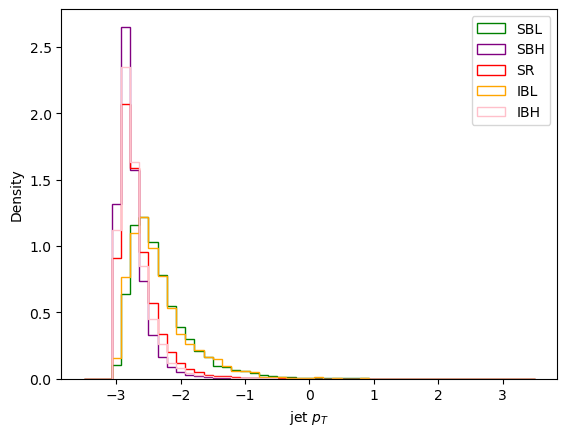

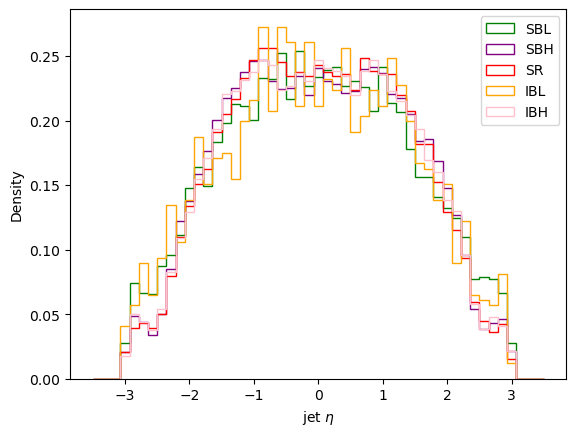

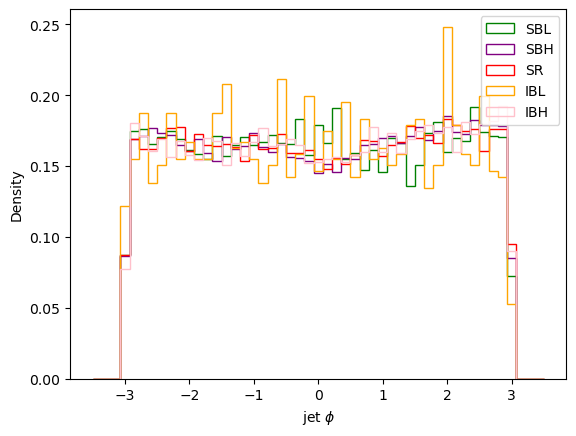

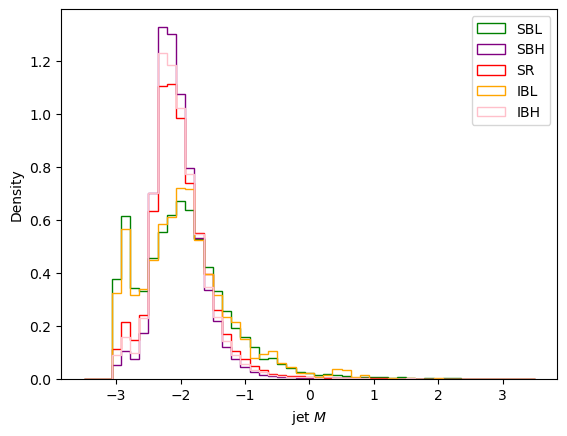

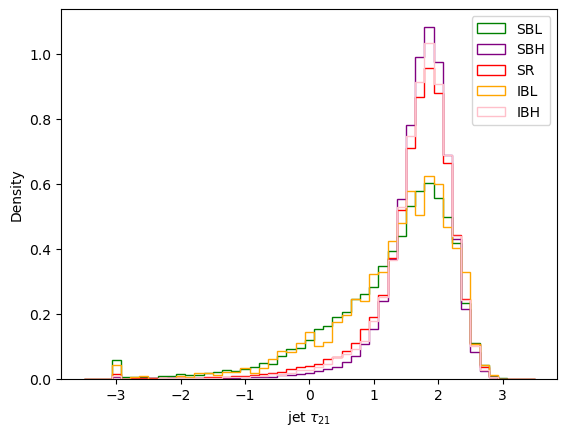

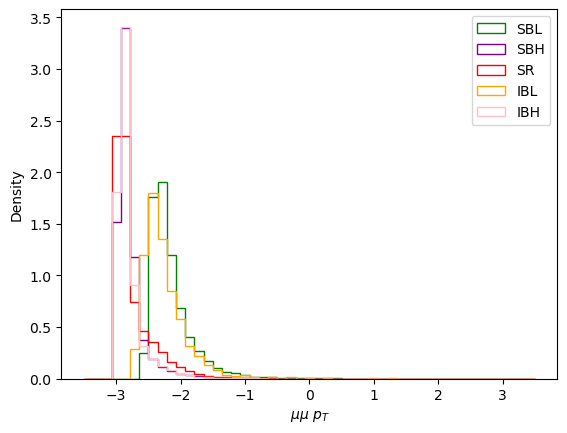

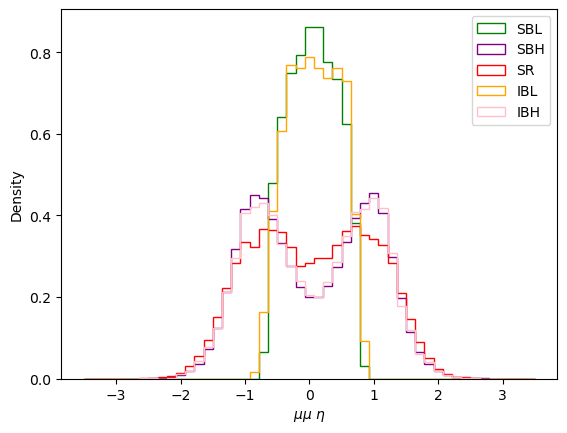

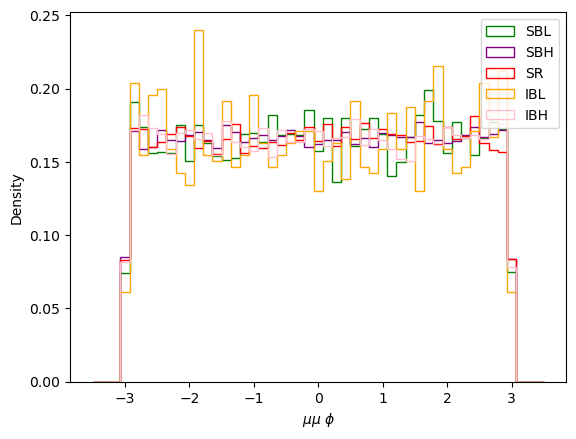

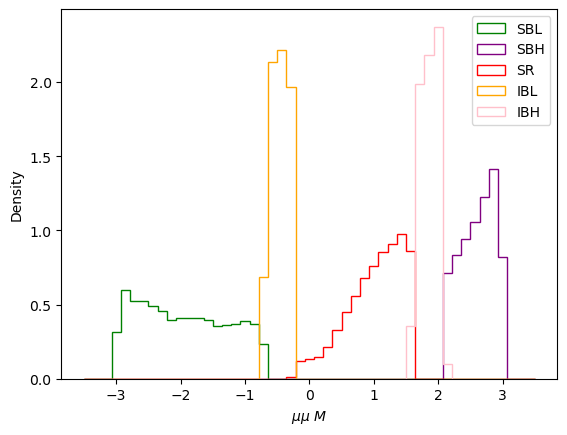

In [4]:
# load in the data

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
data_dict = {}

for b in bands:

    data_dict[b] = np.load(f"processed_data/od_{b}_minmax.npy")
    print("{b} data has shape {length}.".format(b = b, length = data_dict[b].shape))


data_dict["SB"] =  np.vstack((data_dict["SBL"], data_dict["SBH"]))
data_dict["IB"] =  np.vstack((data_dict["IBL"], data_dict["IBH"]))




hist_all_features(["SBL", "SBH", "SR", "IBL", "IBH"], data_dict, kwargs_dict, scaled_bins, image_path = "plots/procc_data")


In [5]:
# train val test split
from sklearn.model_selection import train_test_split

SBL_data_train, SBL_data_val = train_test_split(data_dict["SBL"], test_size=0.2, random_state=42)
SBH_data_train, SBH_data_val = train_test_split(data_dict["SBH"], test_size=0.2, random_state=42)

print(f"SBL train data has shape {SBL_data_train.shape}.")
print(f"SBL val data has shape {SBL_data_val.shape}.")
print(f"SBH train data has shape {SBH_data_train.shape}.")
print(f"SBH val data has shape {SBH_data_val.shape}.")

num_features = 8

SBL train data has shape (7972, 9).
SBL val data has shape (1994, 9).
SBH train data has shape (58702, 9).
SBH val data has shape (14676, 9).


## Flow creation and training

In [6]:
# Create the flow

# This will be the upper subdirectory in saved_models/

num_layers = 2
num_hidden_features = 64
num_blocks = 4
hyperparameters_dict = {"n_epochs":50,
                          "batch_size": 128,
                          "lr": 0.00025,
                          "weight_decay": 0.0001}


flow_training_id = f"Masked_PRQ_AR_{num_layers}layers_{num_hidden_features}hidden_{num_blocks}blocks_{seed}seed"

flow_training_dir = os.path.join("models", f"{flow_training_id}/")
os.makedirs(flow_training_dir, exist_ok=True)




test_flow = make_masked_AR_flow(num_features, num_layers, num_hidden_features, num_blocks)

pytorch_total_params = sum(p.numel() for p in test_flow.parameters() if p.requires_grad)
print(f"Numb. trainable params: {pytorch_total_params}")

Numb. trainable params: 99152


In [ ]:

epochs, losses, losses_val, best_epoch = train_flow_asymm_SB(test_flow, hyperparameters_dict, device, 
                                                    SBL_data_train, SBL_data_val, SBH_data_train, SBH_data_val,
                                                             flow_training_dir, seed = seed)


Training flow for 50 epochs ...



 44%|████▍     | 22/50 [04:56<06:21, 13.63s/it]

In [ ]:
plt.figure()
plt.plot(epochs, losses, label = "loss")
plt.plot(epochs, losses_val, label = "val loss")
plt.legend()
plt.show()

print(best_epoch)

## Evaluate the SB Samples

In [ ]:
# Load in model
config_string = "epochs{0}_lr{1}_wd{2}_bs{3}".format(hyperparameters_dict["n_epochs"], hyperparameters_dict["lr"], hyperparameters_dict["weight_decay"], hyperparameters_dict["batch_size"])
checkpoint_path = os.path.join(flow_training_dir, f"{config_string}")
    

data_dict["SBL_samples"] = sample_from_flow(checkpoint_path, device, data_dict["SBL"][:,-1])
data_dict["SBH_samples"] = sample_from_flow(checkpoint_path, device, data_dict["SBH"][:,-1])
data_dict["SB_samples"] =  np.vstack((data_dict["SBL_samples"], data_dict["SBH_samples"]))


print(data_dict["SBL_samples"].shape)
print(data_dict["SBH_samples"].shape)




In [ ]:
hist_all_features(["SBL", "SBL_samples"], data_dict, kwargs_dict, scaled_bins)
hist_all_features(["SBH", "SBH_samples"], data_dict, kwargs_dict, scaled_bins)



In [ ]:
# Train a BC to discrim SB data from SB samples

hyperparameters_dict_BC = {"n_epochs":100,
                          "batch_size": 128,
                          "lr": 0.001,
                         }

SB_data_train, SB_data_test, SB_samples_train, SB_samples_test = train_test_split(data_dict["SB"], data_dict["SB_samples"], 
                                                                                  test_size=0.1, random_state=42)

print(f"SB data train has shape {SB_data_train.shape}.")
print(f"SB data test has shape {SB_data_test.shape}.")
print(f"SB samples train has shape {SB_samples_train.shape}.")
print(f"SB samples test has shape {SB_samples_test.shape}.")

n_runs = 3
auc_list = []


for i in range(n_runs):


    auc, fpr, tpr, outputs = discriminate_datasets_kfold(flow_training_dir, SB_data_train[:,:-1],  SB_samples_train[:,:-1], 
                                np.ones((SB_data_train.shape[0],1)), np.ones((SB_samples_train.shape[0],1)), 
                                   SB_data_test[:,:-1], SB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 2)


    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(auc))
    
    auc_list.append(auc)



In [ ]:
print(np.mean(auc_list), np.std(auc_list))

print(auc_list)

## Test the inner bands

In [ ]:

data_dict["IBL_samples"] = sample_from_flow(checkpoint_path, device, data_dict["IBL"][:,-1])
data_dict["IBH_samples"] = sample_from_flow(checkpoint_path, device, data_dict["IBH"][:,-1])
data_dict["IB_samples"] =  np.vstack((data_dict["IBL_samples"], data_dict["IBH_samples"]))


print(data_dict["IBL_samples"].shape)
print(data_dict["IBH_samples"].shape)

In [ ]:
hist_all_features(["IBL", "IBL_samples"], data_dict, kwargs_dict, scaled_bins)
hist_all_features(["IBH", "IBH_samples"], data_dict, kwargs_dict, scaled_bins)



In [ ]:

IB_data_train, IB_data_test, IB_samples_train, IB_samples_test = train_test_split(data_dict["IB"], data_dict["IB_samples"], 
                                                                                  test_size=0.1, random_state=42)

print(f"IB data train has shape {IB_data_train.shape}.")
print(f"IB data test has shape {IB_data_test.shape}.")
print(f"IB samples train has shape {IB_samples_train.shape}.")
print(f"IB samples test has shape {IB_samples_test.shape}.")

n_runs = 3
auc_list = []

for i in range(n_runs):


    auc, fpr, tpr, outputs = discriminate_datasets_kfold(flow_training_dir, IB_data_train[:,:-1],  IB_samples_train[:,:-1], 
                                np.ones((IB_data_train.shape[0],1)), np.ones((IB_samples_train.shape[0],1)), 
                                   IB_data_test[:,:-1], IB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 2)


    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(auc))
    
    auc_list.append(auc)


print(np.mean(auc_list), np.std(auc_list))

print(auc_list)